In [70]:
import warnings
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.model_selection import LearningCurve

In [2]:
warnings.simplefilter("ignore", category=ConvergenceWarning)

## 1) Загрузите датасет 20 newsgroups

In [3]:
news = fetch_20newsgroups(subset='all')

## 2) Познакомьтесь с описанием и структурой датасета. Описание можно найти в документации.

In [4]:
print(news.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

## 3) Выведите информацию о количественных параметрах датасета;

In [5]:
news.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [6]:
type(news.data), len(news.data)

(list, 18846)

In [7]:
type(news.target), news.target.shape

(numpy.ndarray, (18846,))

In [8]:
type(news.target_names), len(news.target_names)

(list, 20)

## 4) Выведите несколько точек датасета (сами текстовые фрагменты и значение целевой переменной)

In [9]:
text_id = random.randint(0,news.target.shape[0])
print(news.data[text_id])
print("\n\nARTICLE NAME:")
print(news.target_names[news.target[text_id]])

From: andrem@pyrtech.mis.pyramid.com (Andre Molyneux)
Subject: Re: LCIII->PowerPC?
Reply-To: andrem@pyrtech.mis.pyramid.com (Andre Molyneux)
Organization: Pyramid Technologies, Mt. View, California.
Lines: 34

In article <1qksuq$1tt8@hal.gnu.ai.mit.edu>, mirsky@hal.gnu.ai.mit.edu
(David Joshua Mirsky) writes:
|> Hi. I own an LCIII and I recently heard an interesting rumor.
|> I heard that the LCIII has a built in slot for a PowerPC chip.
|> Is this true? I heard that the slot is not the same as the PDS
|> slot.  Is that true?
|> 
|> Thanks
|> David Mirsky
|> mirsky@gnu.ai.mit.edu

Well, I also have an LC III.  Popping the top revealed:

	One "socket" for an additional VRAM SIMM

	One "socket" for a 72-pin RAM SIMM

	One socket for a flat-pack FPU

	A processor-direct slot (PDS) identical to the LC/LC II, but with
	an additional set of connetions to one side (for the full 32-bit
	data path that the LC/LC II lacked

That's it.  I guess a board with a PowerPC chip could be made that would

## 5) Разделите эти данные на тестовую и обучающую выборки

In [59]:
x_trainx, x_testx, y_train, y_test = train_test_split(news.data, news.target, 
                                                    test_size=0.5,
                                                    random_state=True)

In [60]:
vectorizer = CountVectorizer()

In [61]:
x_train = vectorizer.fit_transform(x_trainx)

In [62]:
x_test = vectorizer.transform(x_testx)

## ***) Необходимые функции

In [24]:
def get_metrics(y_test, y_pred, average, zero_division):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average=average, zero_division=zero_division)
    recall = metrics.recall_score(y_test, y_pred, average=average, zero_division=zero_division)
    return pd.Series(
        (matrix, accuracy, precision, recall),
        index=['confusion matrix', 'accuracy', 'precision', 'recall']
    )
def model_and_metrics(model, average="binary", zero_division="warn", ax_title="",
                      x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)  
    returned = get_metrics(y_test, y_pred, average=average, zero_division=zero_division)
    
    %matplotlib inline
    class_names = [0, 1]
    fig, ax = plt.subplots(figsize=(14,10))
    ax.set_title(ax_title, fontsize=30)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)
    sns.heatmap(pd.DataFrame(
        returned['confusion matrix']),
        annot=True,
                ax=ax
               )
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()  
    return returned

def scorer_precision(estimator, x, y):
    y_pred = estimator.predict(x)
    return metrics.precision_score(y, y_pred, average='weighted', zero_division=0)
    
def scorer_recall(estimator, x, y):
    y_pred = estimator.predict(x)
    return metrics.recall_score(y, y_pred, average='weighted', zero_division=0)
    
def show_statisctic(reg, x, y, title="", train_sizes=np.linspace(0.1, 1, 10), cv=5):
    plt.figure(figsize=(14,10))
    
    for name, scoring, color,linestyle in zip(
        ["accuracy","precision", "recall"],
        ["accuracy", scorer_precision, scorer_recall],
        ["r", "g", "b"],
        ["o-", "o--", "o--"]
    ):
        
        train_sizes, _, test_scores = learning_curve(
            reg,
            x,
            y,
            train_sizes=train_sizes,
            scoring=scoring,
            cv=cv,
        )
        test_scores[np.isnan(test_scores)] = 0
        plt.plot(train_sizes, test_scores.mean(1), linestyle, color=color, label=name)
        
    plt.xlabel("Train size")
    plt.ylabel("score")
    plt.title(title, fontsize=30)
    plt.legend(loc="best")
    plt.show()

### **) Матрица метрик

In [21]:
scores = pd.DataFrame(
    columns=['confusion matrix', 'accuracy', 'precision', 'recall'],
    index=[
        'GaussianNB',
        'MultinomialNB',
        'LogisticRegression',
        'SVC gauss',
        'SVC poly',
        'KNeighborsClassifier',
        'MLPClassifier'
    ]
)
scores

,confusion matrix,accuracy,precision,recall
GaussianNB,NaN,NaN,NaN,NaN
MultinomialNB,NaN,NaN,NaN,NaN
LogisticRegression,NaN,NaN,NaN,NaN
SVC gauss,NaN,NaN,NaN,NaN
SVC poly,NaN,NaN,NaN,NaN
KNeighborsClassifier,NaN,NaN,NaN,NaN
MLPClassifier,NaN,NaN,NaN,NaN


### **) Модели

In [45]:
# модели для обучения
gaussianNB = GaussianNB()
multinomialNB = MultinomialNB()
logisticRegression = LogisticRegression()
svcGauss = svm.SVC(kernel='rbf')
svcPoly = svm.SVC(kernel='poly')
kNeignClass = KNeighborsClassifier()
mlpClass = MLPClassifier()
estimators = [
    gaussianNB,
    multinomialNB,
    logisticRegression,
    svcGauss,
    svcPoly,
    kNeignClass,
    mlpClass
]

In [46]:
estimators

[GaussianNB(),
 MultinomialNB(),
 LogisticRegression(),
 SVC(),
 SVC(kernel='poly'),
 KNeighborsClassifier(),
 MLPClassifier()]

In [77]:
# функции моделей для замера времени
estimator_functions = [
    (GaussianNB(),{})
    (MultinomialNB(), {}),
    (LogisticRegression, {}),
    (svm.SVC, {'kernel':'rbf'}),
    (svm.SVC, {'kernel':'poly'}),
    (KNeighborsClassifier, {}),
    (MLPClassifier, {})
]

<>:3: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:3: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\Nikita\AppData\Local\Temp\ipykernel_8992\3200131656.py:3: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (GaussianNB(),{})
C:\Users\Nikita\AppData\Local\Temp\ipykernel_8992\3200131656.py:3: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (GaussianNB(),{})
C:\Users\Nikita\AppData\Local\Temp\ipykernel_8992\3200131656.py:3: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (GaussianNB(),{})
C:\Users\Nikita\AppData\Local\Temp\ipykernel_8992\3200131656.py:3: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (GaussianNB(),{})
C:\Users\Nikita\AppData\Local\Temp\ipykernel_8992\3200131656.py:3: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (GaussianNB(),{})


TypeError: 'tuple' object is not callable

## 6) Постройте модель наивного байесовского для классификации текстов

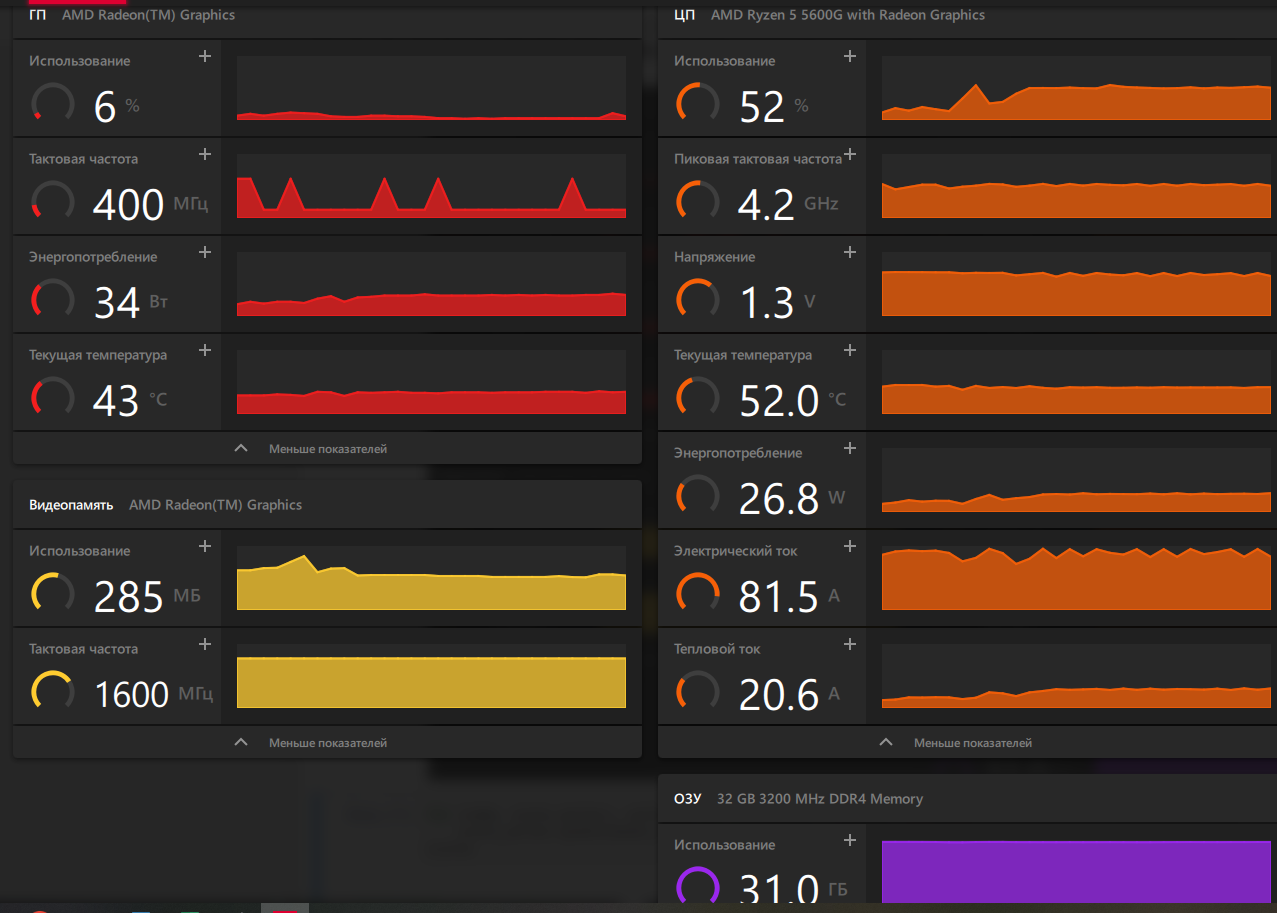

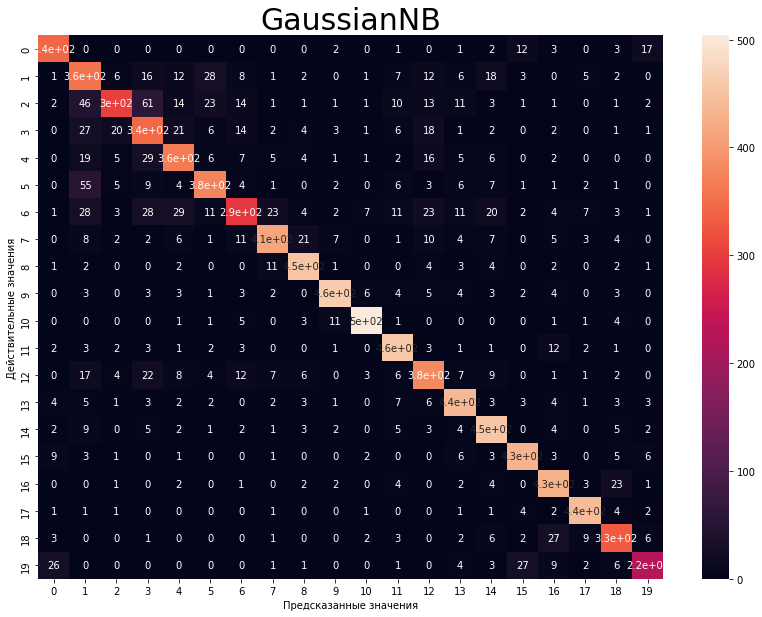

In [27]:
res = model_and_metrics(gaussianNB, x_train=x_train.toarray(), x_test=x_test.toarray(),
                        average="weighted", zero_division=0, ax_title='GaussianNB')

In [33]:
scores.iloc[0] = res

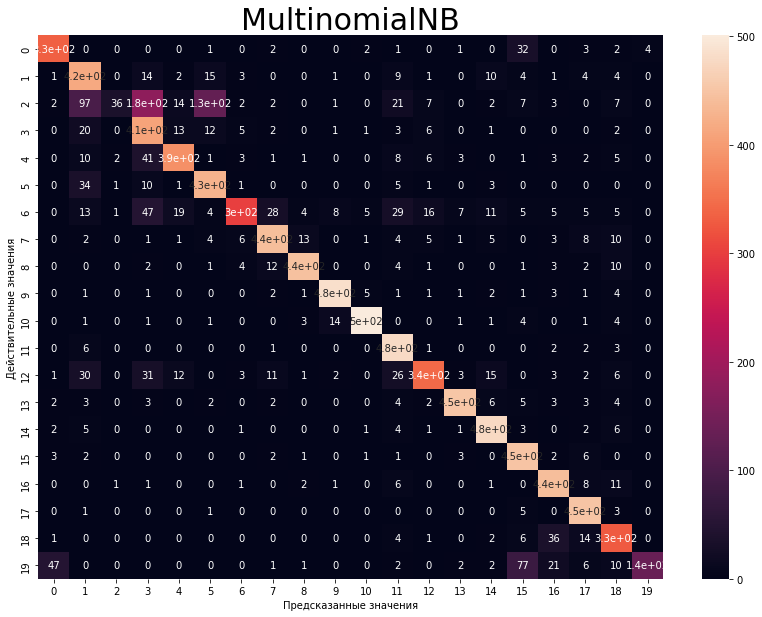

In [47]:
res = model_and_metrics(estimators[1], average="weighted", zero_division=0, ax_title=scores.index[1])
scores.iloc[1] = res

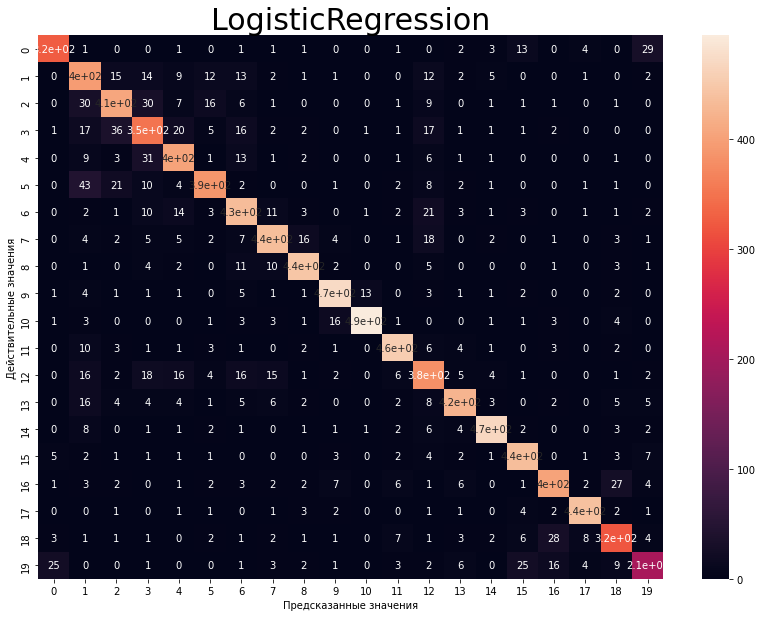

In [48]:
res = model_and_metrics(estimators[2], average="weighted", zero_division=0, ax_title=scores.index[2])
scores.iloc[2] = res

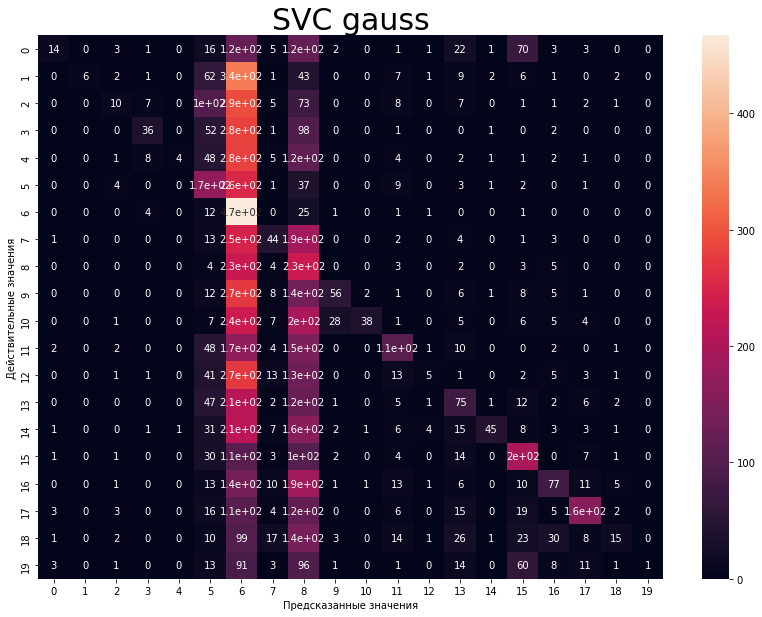

In [49]:
res = model_and_metrics(estimators[3], average="weighted", zero_division=0, ax_title=scores.index[3])
scores.iloc[3] = res

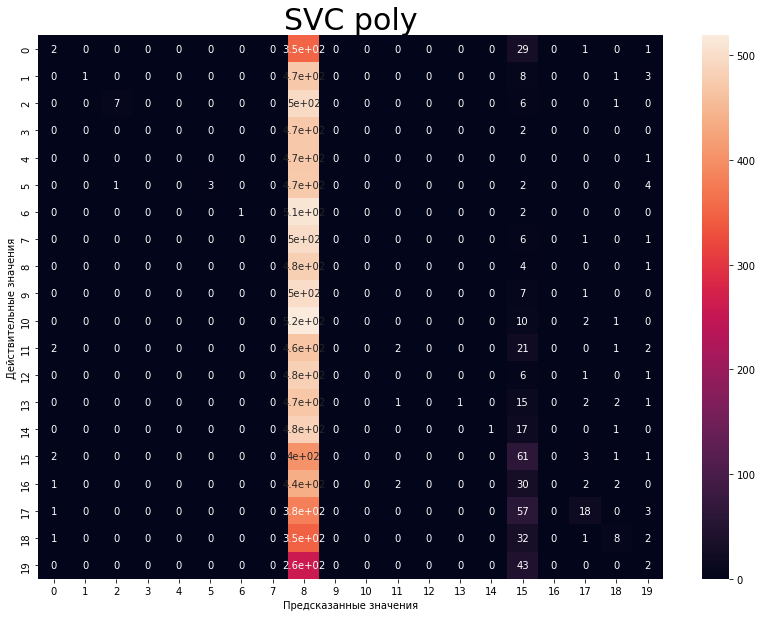

In [50]:
res = model_and_metrics(estimators[4], average="weighted", zero_division=0, ax_title=scores.index[4])
scores.iloc[4] = res

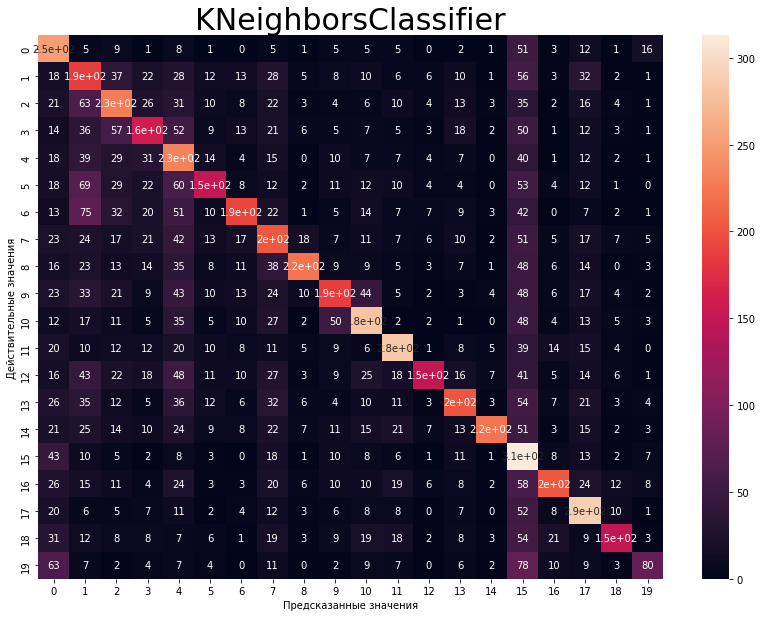

In [51]:
res = model_and_metrics(estimators[5], average="weighted", zero_division=0, ax_title=scores.index[5])
scores.iloc[5] = res

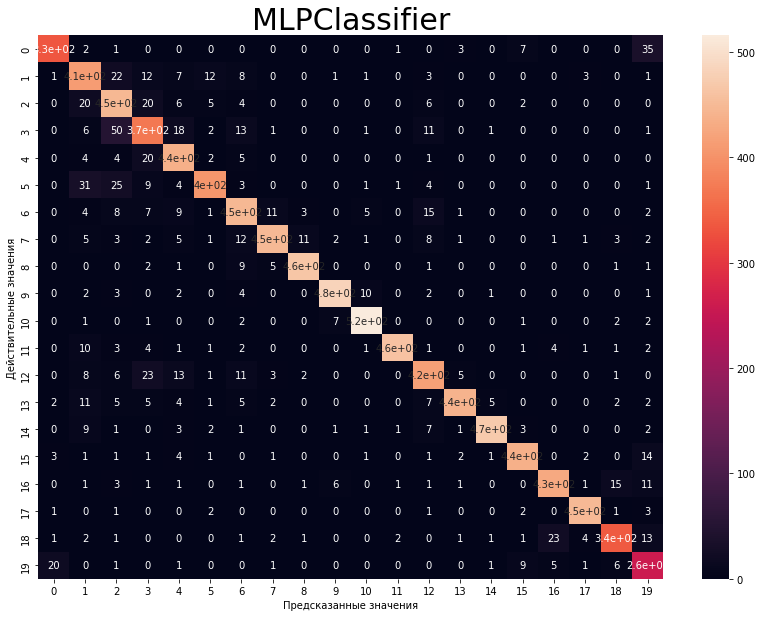

In [52]:
res = model_and_metrics(estimators[6], average="weighted", zero_division=0, ax_title=scores.index[6])
scores.iloc[6] = res

In [53]:
print(scores)

                                                       confusion matrix  \
GaussianNB            [[341, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, ...   
MultinomialNB         [[334, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 1, ...   
LogisticRegression    [[325, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 2, ...   
SVC gauss             [[14, 0, 3, 1, 0, 16, 121, 5, 119, 2, 0, 1, 1,...   
SVC poly              [[2, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, ...   
KNeighborsClassifier  [[251, 5, 9, 1, 8, 1, 0, 5, 1, 5, 5, 5, 0, 2, ...   
MLPClassifier         [[333, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, ...   

                      accuracy precision    recall  
GaussianNB            0.826913  0.829681  0.826913  
MultinomialNB         0.820333  0.841561  0.820333  
LogisticRegression    0.857052  0.859099  0.857052  
SVC gauss             0.186777  0.520276  0.186777  
SVC poly              0.062294  0.399639  0.062294  
KNeighborsClassifier   0.44402  0.513985   0.44402  
MLPClassifier         0.8980

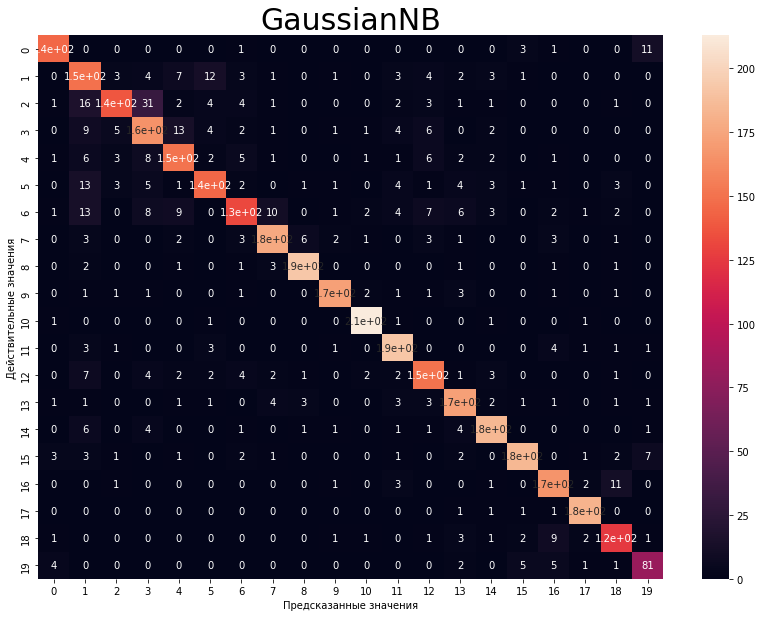

C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


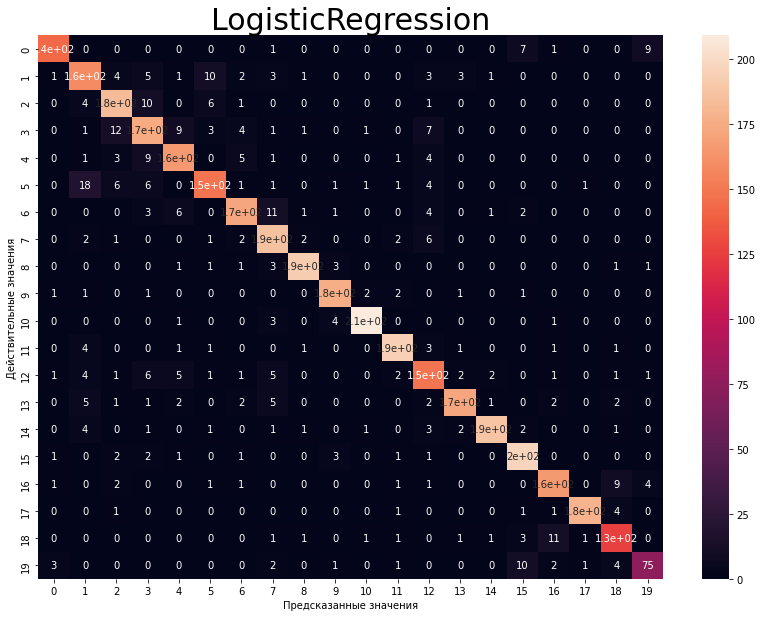

In [ ]:
for (name, score_series), estimator in zip(scores.iterrows(), estimators):
    score_series.update(model_and_metrics(estimator, average="weighted", zero_division=0, ax_title=name))
scores

In [65]:
x_news = CountVectorizer().fit_transform(news.data)

In [73]:
def lerning_curves():
    for estim_func, kwargs in estimator_functions:
        model = LearningCurve(estim_func(**kwargs))
        model.fit(x_news, news.target)
        model.show()

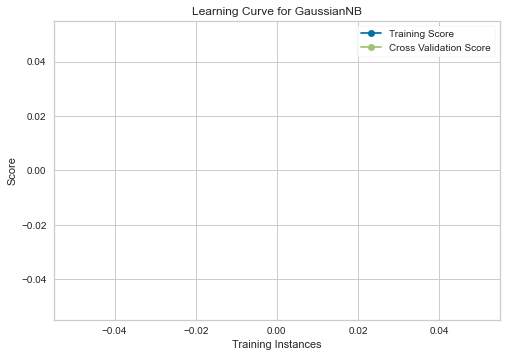

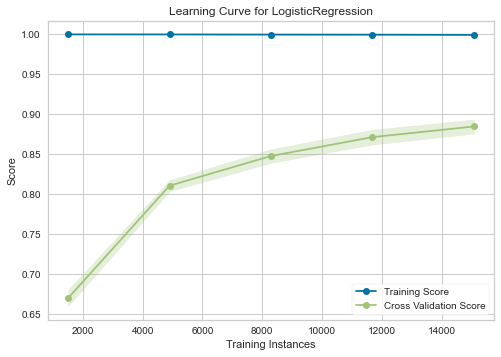

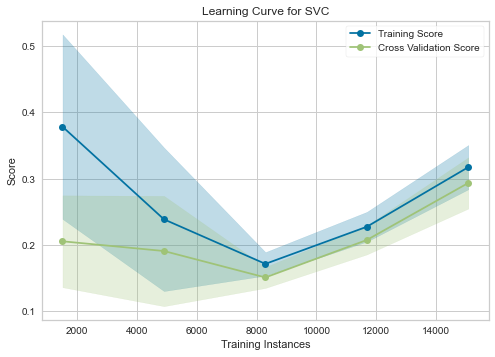

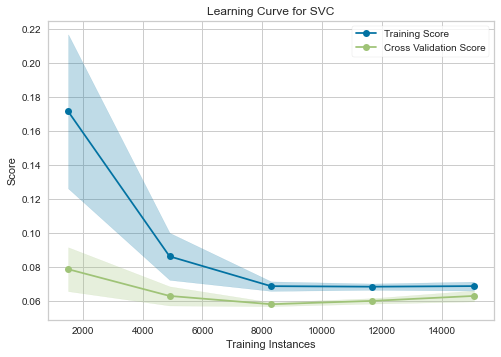

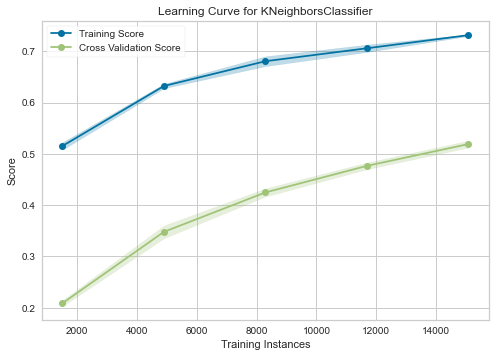

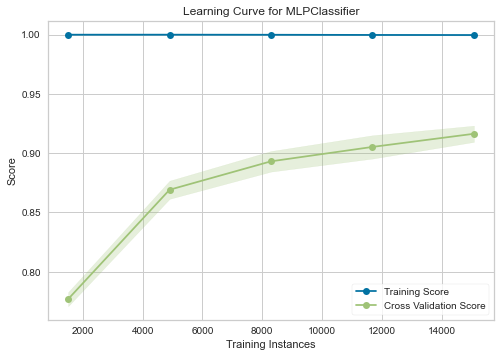

In [74]:
lerning_curves()

C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 83, in predict
    jll = self._joint_log_likelihood(X)
  File "C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 490, in _joint_log_likelihood
    n_ij -= 0.5 * np.sum(((

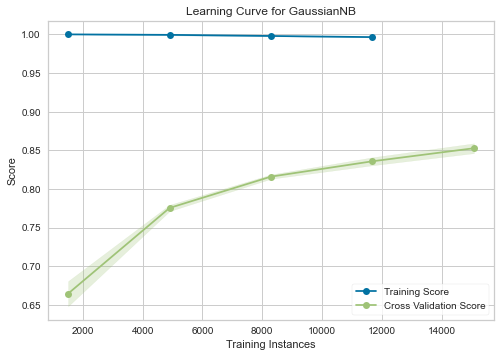

<AxesSubplot:title={'center':'Learning Curve for GaussianNB'}, xlabel='Training Instances', ylabel='Score'>

In [76]:
model = LearningCurve(GaussianNB())
model.fit(x_news.toarray(), news.target)
model.show()

In [ ]:
def timeitx(estimators, iter_count=5, x_train=x_train, y_train=y_train):
    avg_times = []
    for estimator, kwargs in est:
        avg_times.append([])
        for _ in range(iter_count):
            time_start = time.time()
            model = estimator(**kwargs)
            model.fit(x_train, y_train)
            delta = time.time() - time_start
            avg_times[-1].append(delta)
    return [sum(tmsmdl)/len(tmsmdl) for tmsmdl in avg_times]